<a href="https://colab.research.google.com/github/ndvinh98/CS406.L11-Final-Project/blob/main/Training/training_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==1.15

In [2]:
import tensorflow as tf
## slim là package đi kèm với tensorflow, giúp định nghĩa nhanh các loại mô hình deep learning
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from tensorflow.contrib.slim.nets import vgg 
## sklearn là một thư viện rất phổ biến trong ML, chúng ta chỉ sử dụng tran_test_split để chia data thành 2 tập
from sklearn.model_selection import train_test_split
import json
## thư viện tính toán trên matrix
import numpy as np
import cv2
# thư viện hiển thị biểu đồ
import matplotlib.pyplot as plt
import time
import glob
import re
import os
import random
from imutils import paths

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
!unzip /content/drive/'My Drive'/ML/data.zip

In [4]:
!ln -s /content/drive/'My Drive'/ML/backup /content

In [16]:
# kích thước grid system 
cell_size = 7 
# số boundary box cần dự đoán mỗi ô vuông
box_per_cell = 2
# kích thước ảnh đầu vào
img_size = 224
# số loại nhãn
classes = {'gun':0}
nclass = len(classes)

box_scale = 10.0
noobject_scale = 0.1

In [17]:
def load():
    path = 'images/*.*'
    files = glob.glob(path)
    # số lương ảnh
    N = len(files)

    # matrix chứa ảnh
    X = np.zeros((N, img_size, img_size, 3), dtype='uint8')

    # matrix chứa nhãn của ảnh tương ứng
    y = np.zeros((N,cell_size, cell_size, 5+nclass),dtype='uint8')

    # Lấy các đường dẫn đến ảnh.
    image_path = list(paths.list_images('images/'))
    
    # Đổi vị trí ngẫu nhiên các đường dẫn ảnh
    random.shuffle(image_path)

    for (idx, imagePath) in enumerate(image_path):
      img = cv2.imread(imagePath)
      img = cv2.resize(img, (img_size,img_size), interpolation = cv2.INTER_AREA)
      X[idx] = img
      name=os.path.basename(imagePath)
      with open('labels/'+os.path.splitext(name)[0]+'.txt') as f:
          for line in f:
              # tâm của boundary box
              x_center, y_center, w, h = float(line.split()[1])*img_size, float(line.split()[2])*img_size, float(line.split()[3])*img_size, float(line.split()[4])*img_size
              # index của object trên ma trận ô vuông 7x7
              x_idx, y_idx = int(x_center/img_size*cell_size), int(y_center/img_size*cell_size)
              # gán nhãn vào matrix 
              y[idx, y_idx, x_idx] = 1, x_center, y_center, w, h, 1
    return X, y

In [18]:
X, y = load()
#chia train set, test set theo tỉ lệ 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
def vgg16(inputs, is_training,keep_prob):
    """định nghĩa CNN
    Args:
      inputs: 5-D tensor [batch_size, width, height, 3]
    Return:
      4-D tensor [batch_size, 7, 7, 5*nbox + nclass]
    """
    # khái báo scope để có thê group những biến liên quan cho việc visualize trên tensorboard.
    with tf.variable_scope("vgg_16"):
        with slim.arg_scope(vgg.vgg_arg_scope()):
            # hàm repeat có tác dụng lặp lại tầng conv2d n lần mà không phải định nghĩa phức tạp.
            net = slim.repeat(inputs, 2, slim.conv2d, 16, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 32, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 2, slim.conv2d, 64, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 2, slim.conv2d, 256, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')
            # net = slim.repeat(net, 2, slim.conv2d, 512, [3, 3], scope='conv6')
            # net = slim.max_pool2d(net, [2, 2], scope='pool6')
            # net = slim.repeat(net, 2, slim.conv2d, 1024, [3, 3], scope='conv7')
            # net = slim.max_pool2d(net, [2, 2], scope='pool7')
            # thay vì sử dụng 2 tầng fully connected tại đây, 
            # chúng ta sử dụng conv với kernel_size = (1,1) có tác dụng giống hệt tầng fully conntected
            
            net = slim.conv2d(net, 512, [1, 1], scope='fc6') 
            # net = tf.nn.dropout(net, keep_prob, seed=None)  
            net = slim.conv2d(net, 11, [1, 1], activation_fn=None, scope='fc7')

    return net

In [7]:
def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

In [8]:
def compute_iou(boxes1, boxes2, scope='iou'):
    """calculate ious
    Args:
      boxes1: (x_center, y_center, w, h)
      boxes2: (x_center, y_center, w, h)
    Return:
      iou
    """
    with tf.variable_scope(scope):
        # transform (x_center, y_center, w, h) to (x1, y1, x2, y2)
        boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                             boxes1[..., 1] - boxes1[..., 3] / 2.0,
                             boxes1[..., 0] + boxes1[..., 2] / 2.0,
                             boxes1[..., 1] + boxes1[..., 3] / 2.0],
                            axis=-1)

        boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                             boxes2[..., 1] - boxes2[..., 3] / 2.0,
                             boxes2[..., 0] + boxes2[..., 2] / 2.0,
                             boxes2[..., 1] + boxes2[..., 3] / 2.0],
                            axis=-1)

        # calculate the left up point & right down point
        lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
        rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

        # intersection
        intersection = tf.maximum(0.0, rd - lu)
        inter_square = intersection[..., 0] * intersection[..., 1]

        # calculate the boxs1 square and boxs2 square
        square1 = boxes1[..., 2] * boxes1[..., 3]
        square2 = boxes2[..., 2] * boxes2[..., 3]

        union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)

    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)

In [9]:
def loss_layer(predicts, labels, scope='loss_layer'):
    """calculate loss function
    Args:
      predicts: 4-D tensor [batch_size, 7, 7, 5*nbox+n_class] 
      labels: 4-D tensor [batch_size, 7, 7, 5*nbox+n_class]
    Return:
      loss: scalar
    """
    with tf.variable_scope(scope):
        offset = np.transpose(np.reshape(np.array(
            [np.arange(cell_size)] * cell_size * box_per_cell),
            (box_per_cell, cell_size, cell_size)), (1, 2, 0))
        offset = offset[None, :]
        offset = tf.constant(offset, dtype=tf.float32)
        offset_tran = tf.transpose(offset, (0, 2, 1, 3))
        
        # 2 phần tử đầu của vector dự đoán tại một ô vuông là confidence score
        predict_object = predicts[..., :box_per_cell]
        
        # 8 phần tử tiếp theo là dự đoán offset của boundary box và width height
        predict_box_offset = tf.reshape(predicts[...,box_per_cell:5*box_per_cell], (-1, cell_size, cell_size, box_per_cell, 4))
        
        # các phần tử cuối là dự đoán lớp của object
        predict_class = predicts[...,5*box_per_cell:]
        
        # chuyển vị trí offset về toạ độ normalize trên khoảng [0-1]
        predict_normalized_box = tf.stack(
                                    [(predict_box_offset[..., 0] + offset) / cell_size,
                                     (predict_box_offset[..., 1] + offset_tran) / cell_size,
                                     tf.square(predict_box_offset[..., 2]),
                                    tf.square(predict_box_offset[..., 3])], axis=-1)

        # lấy các nhãn tương ứng 
        true_object = labels[..., :1]
        true_box = tf.reshape(labels[..., 1:5], (-1, cell_size, cell_size, 1, 4))
        
        # để normalize tọa độ pixel về đoạn [0-1] chúng ta chia cho img_size (224)
        true_normalized_box = tf.tile(true_box, (1, 1, 1, box_per_cell, 1))/img_size
        true_class = labels[..., 5:]
        
        # tính vị trí offset từ nhãn 
        true_box_offset =  tf.stack(
                                    [true_normalized_box[..., 0] * cell_size - offset,
                                     true_normalized_box[..., 1] * cell_size - offset_tran,
                                     tf.sqrt(true_normalized_box[..., 2]),
                                     tf.sqrt(true_normalized_box[..., 3])], axis=-1)
        
        # tính iou
        predict_iou = compute_iou(true_normalized_box, predict_normalized_box)
        
        # mask chứa vị trí các ô vuông chứa object
        object_mask = tf.reduce_max(predict_iou, 3, keepdims=True)  
        
        # tính metric để monitor 
        iou_metric = tf.reduce_mean(tf.reduce_sum(object_mask, axis=[1,2,3])/tf.reduce_sum(true_object, axis=[1,2,3]))
        
        object_mask = tf.cast((predict_iou>=object_mask), tf.float32)*true_object

        noobject_mask = tf.ones_like(object_mask) - object_mask
        
        ## class loss
        class_delta = true_object*(predict_class - true_class)
        class_loss = tf.reduce_mean(tf.reduce_sum(tf.square(class_delta), axis=[1,2,3]), name='class_loss')
        
        ## object loss
        object_delta = object_mask*(predict_object - predict_iou)
        object_loss = tf.reduce_mean(tf.reduce_sum(tf.square(object_delta), axis=[1,2,3]), name='object_loss')
        
        ## noobject loss
        noobject_delta = noobject_mask*predict_object
        noobject_loss = tf.reduce_mean(tf.reduce_sum(tf.square(noobject_delta), axis=[1,2,3]), name='noobject_loss')
        
        ## coord loss
        box_mask = tf.expand_dims(object_mask, 4)
        box_delta = box_mask*(predict_box_offset - true_box_offset)
        box_loss = tf.reduce_mean(tf.reduce_sum(tf.square(box_delta), axis=[1,2,3]), name='box_loss')
        
        loss = 0.5*class_loss + object_loss + 0.1*noobject_loss + 10*box_loss
        return loss, iou_metric, predict_object, predict_class, predict_normalized_box

In [25]:
def train(learning_rate,epochs,batch_size = 128, optimizer=1):
  tf.reset_default_graph()
  graph = tf.Graph()
  with graph.as_default():    
      # None đại diện cho batch_size, giúp batch_size có thể thay đổi linh hoạt
      images = tf.placeholder("float", [None, img_size, img_size, 3], name="input")
      labels = tf.placeholder('float', [None, cell_size, cell_size, 5+nclass], name='label')
      is_training = tf.placeholder(tf.bool)
      keep_prob = tf.placeholder(tf.float32)

      logits = vgg16(images, is_training,keep_prob)
      loss, iou_metric, predict_object, predict_class, predict_normalized_box = loss_layer(logits, labels)
      
      # định nghĩa adam optimizer, để tối ưu hàm loss
      if optimizer==1:
        optimizer = tf.train.AdamOptimizer(learning_rate)
      elif optimizer==2:
        optimizer = tf.train.RMSPropOptimizer(learning_rate)
      elif optimizer==3:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        
      train_op = optimizer.minimize(loss)
  with tf.Session(graph=graph) as sess:
      sess.run(tf.global_variables_initializer())
      # định nghĩa saver để lưu lại trọng số của mô hình, dùng trong test các ảnh mới
      saver = tf.train.Saver(max_to_keep=1)
      history = []
      for epoch in range(epochs):
          start_time = time.time()
          for batch in range(len(X_train)//batch_size):
              # lấy từng batch, forward, backward, cập nhật trọng số theo adam optimizer
              X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
              y_batch = y_train[batch*batch_size:(batch+1)*batch_size]
              train_total_loss, train_iou_m,_ = sess.run([loss, iou_metric, train_op], {images:X_batch, labels:y_batch, is_training:True,keep_prob:0.5})            
          end_time = time.time()
          
          # tính toán loss, iou trên tập validation
          val_loss = []
          val_iou_ms = []
          result = {}
          for batch in range(len(X_test)//batch_size):
              val_X_batch = X_test[batch*batch_size:(batch+1)*batch_size]
              val_y_batch = y_test[batch*batch_size:(batch+1)*batch_size]
              total_val_loss, val_iou_m, val_predict_object, val_predict_class, val_predict_normalized_box = \
                                                    sess.run([loss, iou_metric, predict_object, predict_class, predict_normalized_box], \
                                                  {images:val_X_batch, labels:val_y_batch, is_training:False,keep_prob:1.0})
              val_loss.append(total_val_loss)
              val_iou_ms.append(val_iou_m)
              
          saver.save(sess, './backup/yolo', global_step=epoch)
          result.update({
              "epoch":epoch,
              "train_loss":train_total_loss,
              "train_iou":train_iou_m,
              "val_loss":np.mean(val_loss),
              "val_iou":np.mean(val_iou_ms),
          })
          print('epoch: {} - running_time: {:.0f}s - train_loss: {:.3f} - train_iou: {:.3f} - val_loss: {:.3f} - val_iou: {:.3f}'
                                      .format(epoch, end_time - start_time, train_total_loss, train_iou_m, np.mean(val_loss), np.mean(val_iou_ms)))
          history.append(result)
      return history

In [11]:
def show_chart(history, learning_rate, bacth_size):
  epochs = [ item.get("epoch") for item in history]
  train_loss = [ item.get("train_loss") for item in history]
  val_loss = [ item.get("val_loss") for item in history]
  train_iou = [ item.get("train_iou") for item in history]
  val_iou = [ item.get("val_iou") for item in history]

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
  fig.suptitle("Performance of Model - lr= {} - batch size = {}".format(learning_rate,bacth_size))
  ax1.plot(train_loss)
  ax1.plot(val_loss)
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_title("Model Loss")
  ax1.legend(['train loss', 'val loss'])

  ax2.plot(train_iou)
  ax2.plot(val_iou)
  ax2.set_ylabel('IOU')
  ax2.set_xlabel('Epochs')
  ax2.set_title("Model IOU")
  ax2.legend(['train iou', 'val iou'])
  plt.show()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
epoch: 0 - running_time: 16s - train_loss: 1.046 - train_iou: 0.277 - val_loss: 0.951 - val_iou: 0.281
Instructions for updating:
Use standard file APIs to delete files with this prefix.
epoch: 1 - running_time: 5s - train_loss: 0.964 - train_iou: 0.327 - val_loss: 0.901 - val_iou: 0.319
epoch: 2 - running_time: 5s - train_loss: 0.935 - train_iou: 0.361 - val_loss: 0.867 - val_iou: 0.343
epoch: 3 - running_time: 5s - train_loss: 0.894 - train_iou: 0.378 - val_loss: 0.815 - val_iou: 0.343
epoch: 4 - running_time: 5s - train_loss: 0.841 - train_iou: 0.369 - val_loss: 0.778 - val_iou: 0.358
epoch: 5 - running_time: 5s - train_loss: 0.821 - train_iou: 0.361 - val_loss: 0.744 - val_iou: 0.375
epoch: 6 - running_time: 5s - train_loss: 0.792 - train_iou: 0.353 - val_loss: 0.716 - val_iou: 0.362
epoch: 7 - running_time: 5s - train_loss: 0.766 - train_iou: 0.411 - val_loss: 0.691 - val_iou: 0.421
epoch

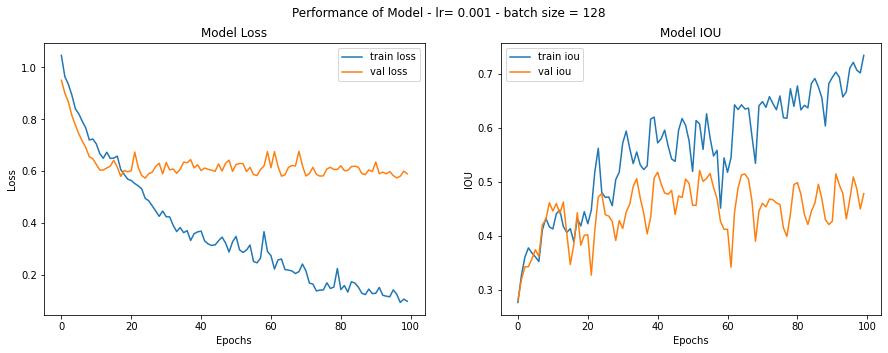

In [20]:
H = train(learning_rate=1e-3, epochs=100, batch_size=128)
show_chart(H,1e-3,128)

In [21]:
H1 = train(learning_rate=1e-2, epochs=70, batch_size=128)
show_chart(H1,1e-2,128)

epoch: 0 - running_time: 6s - train_loss: 1.552 - train_iou: 0.196 - val_loss: 1.261 - val_iou: 0.257
epoch: 1 - running_time: 5s - train_loss: 0.893 - train_iou: 0.480 - val_loss: 0.762 - val_iou: 0.473
epoch: 2 - running_time: 5s - train_loss: 0.843 - train_iou: 0.370 - val_loss: 0.729 - val_iou: 0.365
epoch: 3 - running_time: 5s - train_loss: 0.832 - train_iou: 0.365 - val_loss: 0.746 - val_iou: 0.342
epoch: 4 - running_time: 5s - train_loss: 0.815 - train_iou: 0.391 - val_loss: 0.710 - val_iou: 0.372
epoch: 5 - running_time: 5s - train_loss: 0.812 - train_iou: 0.377 - val_loss: 0.721 - val_iou: 0.359
epoch: 6 - running_time: 5s - train_loss: 0.813 - train_iou: 0.379 - val_loss: 0.721 - val_iou: 0.361
epoch: 7 - running_time: 5s - train_loss: 0.811 - train_iou: 0.381 - val_loss: 0.717 - val_iou: 0.363
epoch: 8 - running_time: 5s - train_loss: 0.813 - train_iou: 0.380 - val_loss: 0.718 - val_iou: 0.362
epoch: 9 - running_time: 5s - train_loss: 0.813 - train_iou: 0.378 - val_loss: 0.7

KeyboardInterrupt: ignored

In [22]:
H2 = train(learning_rate=5e-3, epochs=50, batch_size=128)
show_chart(H2,1e-1,128)

epoch: 0 - running_time: 6s - train_loss: 1.659 - train_iou: 0.159 - val_loss: 1.314 - val_iou: 0.335
epoch: 1 - running_time: 5s - train_loss: 1.212 - train_iou: 0.415 - val_loss: 0.935 - val_iou: 0.454
epoch: 2 - running_time: 5s - train_loss: 0.891 - train_iou: 0.385 - val_loss: 0.794 - val_iou: 0.407
epoch: 3 - running_time: 5s - train_loss: 0.829 - train_iou: 0.389 - val_loss: 0.744 - val_iou: 0.360
epoch: 4 - running_time: 5s - train_loss: 0.877 - train_iou: 0.325 - val_loss: 0.769 - val_iou: 0.338
epoch: 5 - running_time: 5s - train_loss: 0.799 - train_iou: 0.419 - val_loss: 0.727 - val_iou: 0.351
epoch: 6 - running_time: 5s - train_loss: 0.789 - train_iou: 0.417 - val_loss: 0.698 - val_iou: 0.407
epoch: 7 - running_time: 5s - train_loss: 0.792 - train_iou: 0.442 - val_loss: 0.691 - val_iou: 0.393
epoch: 8 - running_time: 5s - train_loss: 0.776 - train_iou: 0.434 - val_loss: 0.685 - val_iou: 0.408
epoch: 9 - running_time: 5s - train_loss: 0.763 - train_iou: 0.403 - val_loss: 0.6

KeyboardInterrupt: ignored

In [24]:
H3 = train(learning_rate=1e-4, epochs=200, batch_size=128)
show_chart(H3,1e-4,128)

epoch: 0 - running_time: 6s - train_loss: 1.152 - train_iou: 0.317 - val_loss: 1.065 - val_iou: 0.326
epoch: 1 - running_time: 5s - train_loss: 0.964 - train_iou: 0.359 - val_loss: 0.889 - val_iou: 0.360
epoch: 2 - running_time: 5s - train_loss: 0.912 - train_iou: 0.363 - val_loss: 0.835 - val_iou: 0.367
epoch: 3 - running_time: 5s - train_loss: 0.884 - train_iou: 0.370 - val_loss: 0.818 - val_iou: 0.372
epoch: 4 - running_time: 5s - train_loss: 0.852 - train_iou: 0.373 - val_loss: 0.802 - val_iou: 0.374
epoch: 5 - running_time: 5s - train_loss: 0.827 - train_iou: 0.378 - val_loss: 0.790 - val_iou: 0.374
epoch: 6 - running_time: 5s - train_loss: 0.802 - train_iou: 0.374 - val_loss: 0.787 - val_iou: 0.371
epoch: 7 - running_time: 5s - train_loss: 0.777 - train_iou: 0.377 - val_loss: 0.771 - val_iou: 0.379
epoch: 8 - running_time: 5s - train_loss: 0.756 - train_iou: 0.381 - val_loss: 0.761 - val_iou: 0.384
epoch: 9 - running_time: 5s - train_loss: 0.735 - train_iou: 0.375 - val_loss: 0.7

KeyboardInterrupt: ignored

In [26]:
H3 = train(learning_rate=1e-3, epochs=100, batch_size=128, optimizer=2)
show_chart(H3,1e-3,128)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 0 - running_time: 6s - train_loss: 1.646 - train_iou: 0.411 - val_loss: 2.930 - val_iou: 0.041
epoch: 1 - running_time: 5s - train_loss: 4.395 - train_iou: 0.003 - val_loss: 2.159 - val_iou: 0.089
epoch: 2 - running_time: 5s - train_loss: 1.296 - train_iou: 0.249 - val_loss: 2.728 - val_iou: 0.259
epoch: 3 - running_time: 5s - train_loss: 3.241 - train_iou: 0.022 - val_loss: 2.316 - val_iou: 0.078
epoch: 4 - running_time: 5s - train_loss: 0.944 - train_iou: 0.428 - val_loss: 1.099 - val_iou: 0.226
epoch: 5 - running_time: 5s - train_loss: 0.910 - train_iou: 0.435 - val_loss: 1.074 - val_iou: 0.222
epoch: 6 - running_time: 5s - train_loss: 0.880 - train_iou: 0.423 - val_loss: 0.986 - val_iou: 0.242
epoch: 7 - running_time: 5s - train_loss: 0.819 - train_iou: 0.413 - val_loss: 0.740 - val_iou: 0.325
epoch: 8 - running_time: 5s - train_loss: 0.863 - train_iou: 0.529

KeyboardInterrupt: ignored